In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision.models.alexnet import AlexNet_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.svm import LinearSVC

/Users/nikoletaulama/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Resize the images

In [3]:
def resize_transformation(img):
    resize = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
    i = resize(img)
    return i

Import datasets

In [4]:
train_dataset = ImageFolder(root="../train", transform=resize_transformation)
test_dataset = ImageFolder(root="../test", transform=resize_transformation)

Split the training set in 85% for actual training set and 15% to be used as validation set

In [5]:
train_size = int(0.85 * len(train_dataset))
validation_size = len(train_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

In [6]:
class Augmentation:

    def __init__(self, ds):
        self.ds = ds
        self.transformation = transforms.RandomHorizontalFlip(1)

    def __getitem__(self, index):
        img, label = self.ds[index]

        if self.transformation:
            img = self.transformation(img)

        return img, label

    def __len__(self):
        return len(self.ds)

Minibatches of size 32; 
Apply augmentation

In [7]:
batch_size = 32
augmented_training_set = Augmentation(training_set)
concatenated_dataset = torch.utils.data.ConcatDataset(
    [training_set, augmented_training_set]
)
augmented_train_loader = DataLoader(
    concatenated_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

validation_loader = DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, pin_memory=True
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Network layout

In [8]:
class CNN(nn.Module):  
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=7, padding=3)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.25)  

        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)  
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu_fc1(x)  
        x = self.fc2(x)
        return x

In [9]:
model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

In [10]:
for param in model.parameters():
    param.requires_grad = False

SVM

In [11]:
def svm(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, label in loader:
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())

            labels.append(label.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [12]:
train_features, train_labels = svm(model, augmented_train_loader)
test_features, test_labels = svm(model, test_loader)

In [13]:
svm = LinearSVC(random_state=123)

In [14]:
svm.fit(train_features,train_labels)

/Users/nikoletaulama/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nikoletaulama/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=123)

Test and Accuracy and Confusion Matrix

Accuracy of the network on the test images: 79.46%


<Axes: >

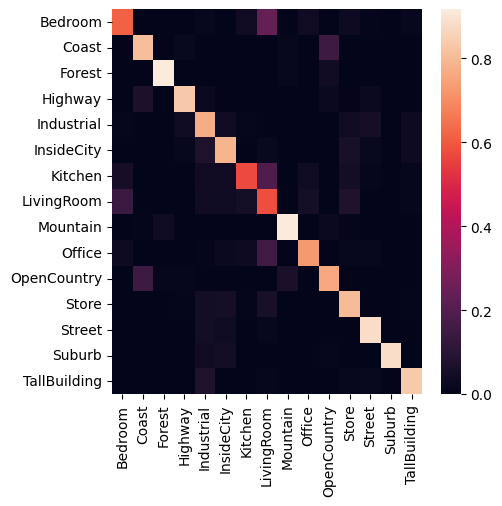

In [15]:
accuracy = svm.score(test_features, test_labels)
print(f"Accuracy of the network on the test images: {100 * accuracy:.2f}%")
predictions = svm.predict(test_features)
classes = test_dataset.classes
cf_matrix = confusion_matrix(np.stack(predictions), np.stack(test_labels))
df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
    index=[i for i in classes],
    columns=[i for i in classes],
)
plt.figure(figsize=(5, 5))
sn.heatmap(df_cm)